SETUP DAN IMPORT LIBRARY

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns
import pandas as pd
import numpy as np
import os
from PIL import Image
import random
import warnings

warnings.filterwarnings('ignore')
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.20.0


Konfigurasi Path dan Download Dataset

In [2]:
dataset_path = "./datasets/corn_leaf_disease/data"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset tidak ditemukan di: {dataset_path}")

classes = sorted([d.name for d in os.scandir(dataset_path) if d.is_dir()])
all_filepaths = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(dataset_path)) for f in fn if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
all_labels = [os.path.basename(os.path.dirname(fp)) for fp in all_filepaths]
df = pd.DataFrame({'filepath': all_filepaths, 'label': all_labels})
print("--- DISTRIBUSI DATA ASLI ---")
print(df['label'].value_counts())
print(f"Total gambar: {len(df)}\n")

--- DISTRIBUSI DATA ASLI ---
label
Common_Rust       1306
Healthy           1162
Blight            1146
Gray_Leaf_Spot     574
Name: count, dtype: int64
Total gambar: 4188



Visualisasi

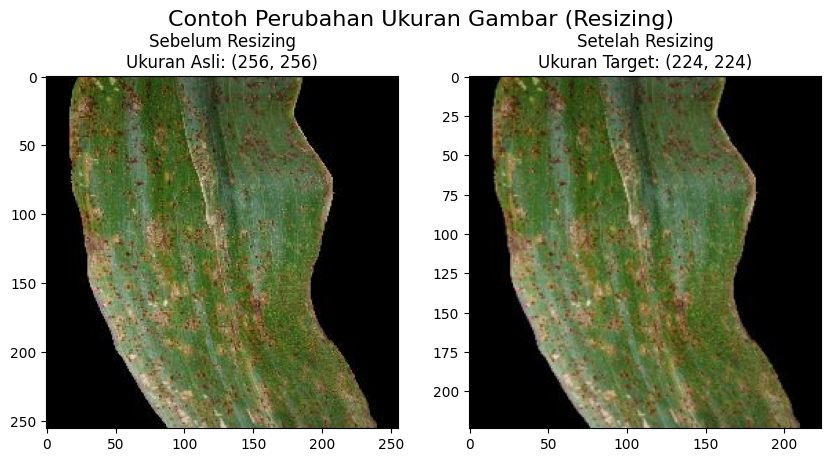


--- Menampilkan Contoh Hasil Augmentasi ---


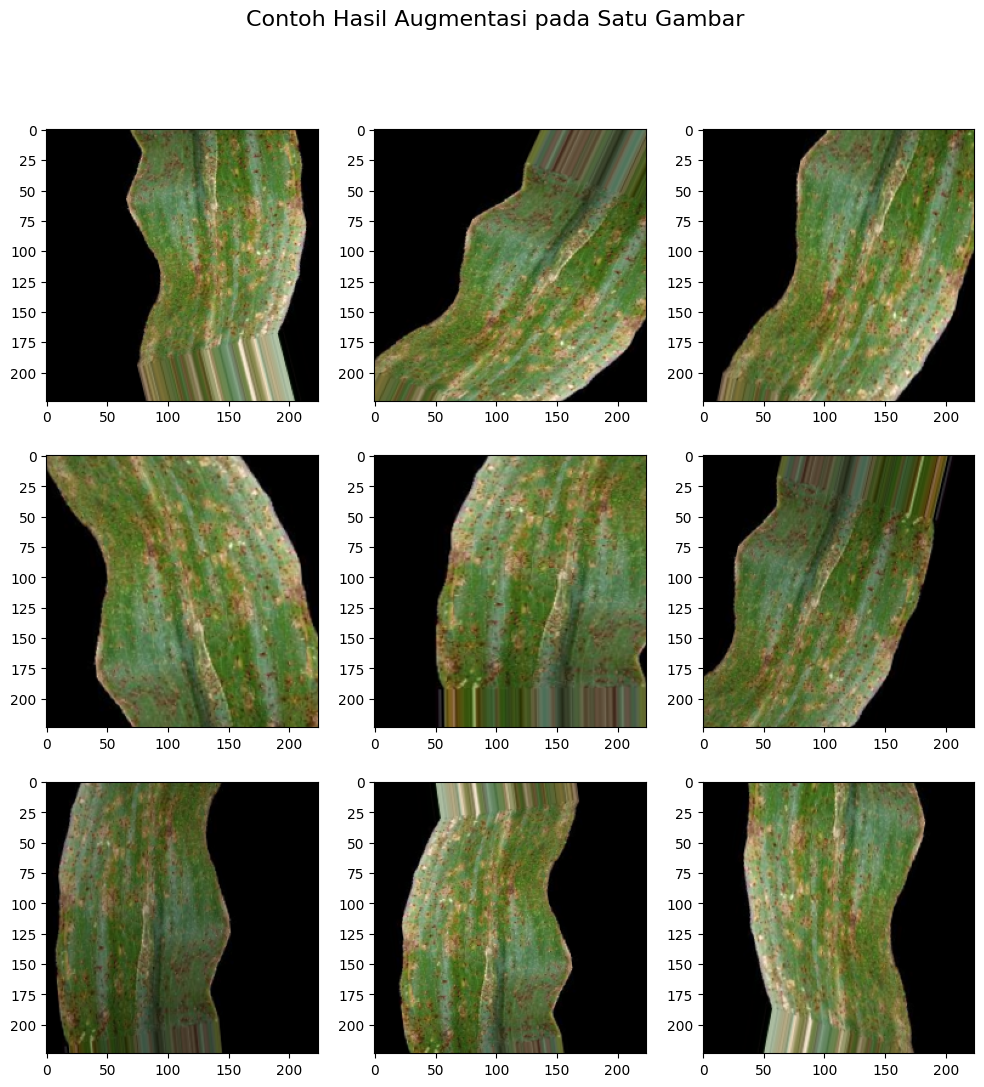

In [3]:
IMG_SIZE = (224, 224)
sample_image_path = random.choice(df['filepath'].tolist())
sample_image = Image.open(sample_image_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title(f"Sebelum Resizing\nUkuran Asli: {sample_image.size}")
plt.subplot(1, 2, 2)
resized_image = sample_image.resize(IMG_SIZE)
plt.imshow(resized_image)
plt.title(f"Setelah Resizing\nUkuran Target: {IMG_SIZE}")
plt.suptitle("Contoh Perubahan Ukuran Gambar (Resizing)", fontsize=16)
plt.show()

print("\n--- Menampilkan Contoh Hasil Augmentasi ---")
preview_datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
    vertical_flip=True, brightness_range=[0.8, 1.2], fill_mode='nearest'
)
sample_array = img_to_array(resized_image)
sample_array = sample_array.reshape((1,) + sample_array.shape)

plt.figure(figsize=(12, 12))
plt.suptitle("Contoh Hasil Augmentasi pada Satu Gambar", fontsize=16)
i = 0
for batch in preview_datagen.flow(sample_array, batch_size=1):
    plt.subplot(3, 3, i + 1)
    plt.imshow(batch[0].astype('uint8'))
    i += 1
    if i % 9 == 0:
        break
plt.show()

Pembagian Data

In [4]:
train_val_df, test_df = train_test_split(
    df, test_size=0.1, 
    random_state=42, 
    stratify=df['label']
)
print(f"\nUkuran Data untuk K-Fold (Latih+Validasi): {len(train_val_df)}")
print(f"Ukuran Data Uji Final: {len(test_df)}\n")


Ukuran Data untuk K-Fold (Latih+Validasi): 3769
Ukuran Data Uji Final: 419



Augmentasi Data

Distribusi data sebelum augmentasi:
label
Common_Rust       1175
Healthy           1046
Blight            1031
Gray_Leaf_Spot     517
Name: count, dtype: int64
Target sampel per kelas untuk augmentasi: 1175

Distribusi data setelah augmentasi (untuk K-Fold):
label
Healthy           1175
Common_Rust       1175
Blight            1175
Gray_Leaf_Spot    1175
Name: count, dtype: int64


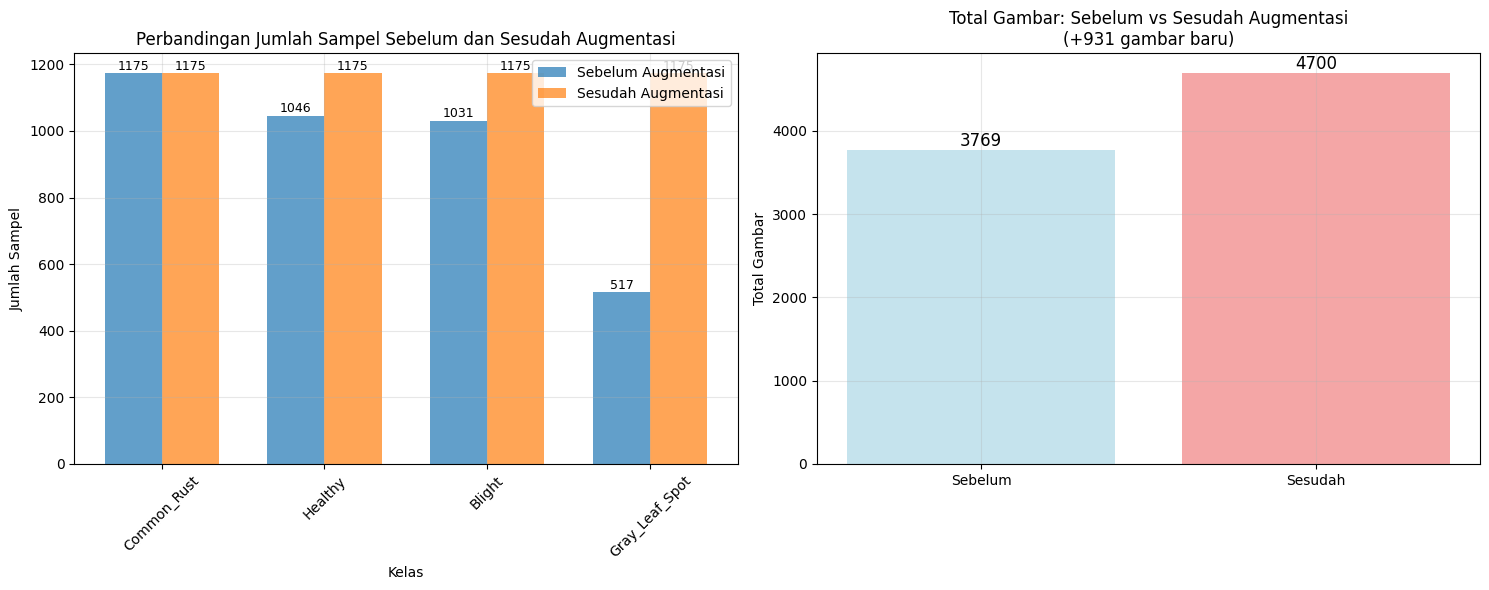


=== STATISTIK AUGMENTASI ===
Total gambar sebelum augmentasi: 3769
Total gambar sesudah augmentasi: 4700
Jumlah gambar yang ditambahkan: 931
Persentase peningkatan: 24.70%

=== DETAIL PER KELAS ===
Kelas Common_Rust: 1175 → 1175 (+0)
Kelas Healthy: 1046 → 1175 (+129)
Kelas Blight: 1031 → 1175 (+144)
Kelas Gray_Leaf_Spot: 517 → 1175 (+658)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def augment_training_data(df):
    original_counts = df['label'].value_counts()
    target_samples = original_counts.max()
    print(f"Target sampel per kelas untuk augmentasi: {target_samples}")
    
    augment_datagen = ImageDataGenerator(
        rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
    )
    
    augmented_data = []
    for class_name in df['label'].unique():
        class_df = df[df['label'] == class_name]
        samples_needed = target_samples - len(class_df)
        if samples_needed > 0:
            samples_to_augment = class_df.sample(n=samples_needed, replace=True, random_state=42)
            for _, sample in samples_to_augment.iterrows():
                try:
                    img = Image.open(sample['filepath']).convert('RGB')
                    img_array = np.array(img)
                    augmented = augment_datagen.random_transform(img_array)
                    augmented_img = Image.fromarray(augmented.astype('uint8'))
                    name, ext = os.path.splitext(os.path.basename(sample['filepath']))
                    new_filename = f"{name}_aug_{np.random.randint(10000)}{ext}"
                    new_filepath = os.path.join(os.path.dirname(sample['filepath']), new_filename)
                    augmented_img.save(new_filepath)
                    augmented_data.append({'filepath': new_filepath, 'label': class_name})
                except Exception as e:
                    print(f"Error augmenting {sample['filepath']}: {e}")
    
    if augmented_data:
        augmented_df = pd.DataFrame(augmented_data)
        return pd.concat([df, augmented_df], ignore_index=True)
    return df

print("Distribusi data sebelum augmentasi:")
before_augmentation = train_val_df['label'].value_counts()
print(before_augmentation)

# Augmentasi
balanced_train_val_df = augment_training_data(train_val_df.copy())

print("\nDistribusi data setelah augmentasi (untuk K-Fold):")
after_augmentation = balanced_train_val_df['label'].value_counts()
print(after_augmentation)

# Visualisasi perbandingan sebelum dan sesudah augmentasi
def visualize_augmentation_comparison(before, after):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    classes = before.index
    x = np.arange(len(classes))
    width = 0.35
    
    plt.bar(x - width/2, before.values, width, label='Sebelum Augmentasi', alpha=0.7)
    plt.bar(x + width/2, after.values, width, label='Sesudah Augmentasi', alpha=0.7)
    
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Sampel')
    plt.title('Perbandingan Jumlah Sampel Sebelum dan Sesudah Augmentasi')
    plt.xticks(x, classes, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    for i, v in enumerate(before.values):
        plt.text(i - width/2, v + 0.5, str(v), ha='center', va='bottom', fontsize=9)
    for i, v in enumerate(after.values):
        plt.text(i + width/2, v + 0.5, str(v), ha='center', va='bottom', fontsize=9)
    
    plt.subplot(1, 2, 2)
    total_before = before.sum()
    total_after = after.sum()
    added_samples = total_after - total_before
    
    categories = ['Sebelum', 'Sesudah']
    totals = [total_before, total_after]
    colors = ['lightblue', 'lightcoral']
    
    bars = plt.bar(categories, totals, color=colors, alpha=0.7)
    plt.ylabel('Total Gambar')
    plt.title(f'Total Gambar: Sebelum vs Sesudah Augmentasi\n(+{added_samples} gambar baru)')
    plt.grid(True, alpha=0.3)
    
    for bar, total in zip(bars, totals):
        plt.text(bar.get_x() + bar.get_width()/2, total + 0.5, str(total), 
                ha='center', va='bottom', fontsize=12)
    
    plt.tight_layout()
    plt.show()

visualize_augmentation_comparison(before_augmentation, after_augmentation)

print(f"\n=== STATISTIK AUGMENTASI ===")
print(f"Total gambar sebelum augmentasi: {before_augmentation.sum()}")
print(f"Total gambar sesudah augmentasi: {after_augmentation.sum()}")
print(f"Jumlah gambar yang ditambahkan: {after_augmentation.sum() - before_augmentation.sum()}")
print(f"Persentase peningkatan: {((after_augmentation.sum() - before_augmentation.sum()) / before_augmentation.sum() * 100):.2f}%")

print(f"\n=== DETAIL PER KELAS ===")
for class_name in before_augmentation.index:
    before_count = before_augmentation[class_name]
    after_count = after_augmentation[class_name]
    added = after_count - before_count
    print(f"Kelas {class_name}: {before_count} → {after_count} (+{added})")

Proses Training

In [6]:
BATCH_SIZE = 32
NUM_FOLDS = 5
INITIAL_EPOCHS = 7
FINE_TUNE_EPOCHS = 13
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

kfold = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
fold_scores, all_histories = [], []

train_datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
    preprocessing_function=preprocess_input
)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def create_model():
    base_model = ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
    base_model.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x); x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x); x = layers.Dropout(0.5)(x)
    x = layers.Dense(len(classes), activation='softmax')(x)
    return models.Model(inputs=base_model.input, outputs=x), base_model

for fold, (train_ids, val_ids) in enumerate(kfold.split(balanced_train_val_df)):
    print(f"\n{'='*20} MEMULAI FOLD {fold + 1}/{NUM_FOLDS} {'='*20}")
    train_fold_df = balanced_train_val_df.iloc[train_ids]
    val_fold_df = balanced_train_val_df.iloc[val_ids]
    train_generator = train_datagen.flow_from_dataframe(
        train_fold_df, x_col='filepath', y_col='label', target_size=IMG_SIZE,
        class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True
    )
    val_generator = val_test_datagen.flow_from_dataframe(
        val_fold_df, x_col='filepath', y_col='label', target_size=IMG_SIZE,
        class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
    )
    
    model, base_model = create_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    print("\n--- TAHAP 1: FEATURE EXTRACTION ---")
    history_phase1 = model.fit(
        train_generator, 
        epochs=INITIAL_EPOCHS, 
        validation_data=val_generator, 
        verbose=2
    )
    
    print("\n--- TAHAP 2: FINE-TUNING ---")
    base_model.trainable = True
    for layer in base_model.layers[:249]:
        layer.trainable = False
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])
                  
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    
    history_phase2 = model.fit(
        train_generator, 
        epochs=TOTAL_EPOCHS, 
        initial_epoch=history_phase1.epoch[-1],
        validation_data=val_generator, 
        callbacks=[early_stopping], 
        verbose=2
    )
    
    scores = model.evaluate(val_generator, verbose=0)
    print(f"Skor Fold {fold + 1}: Loss={scores[0]:.4f}, Accuracy={scores[1]*100:.2f}%")
    fold_scores.append(scores[1])
    history = {key: history_phase1.history[key] + history_phase2.history[key] for key in history_phase1.history}
    all_histories.append(history)


==================== MEMULAI FOLD 1/5 ====================
Found 3760 validated image filenames belonging to 4 classes.
Found 940 validated image filenames belonging to 4 classes.

--- TAHAP 1: FEATURE EXTRACTION ---
Epoch 1/7
118/118 - 149s - 1s/step - accuracy: 0.8168 - loss: 2.3224 - val_accuracy: 0.8383 - val_loss: 2.1513
Epoch 2/7
118/118 - 123s - 1s/step - accuracy: 0.8609 - loss: 1.9099 - val_accuracy: 0.8628 - val_loss: 1.7824
Epoch 3/7
118/118 - 124s - 1s/step - accuracy: 0.8782 - loss: 1.6698 - val_accuracy: 0.8702 - val_loss: 1.6011
Epoch 4/7
118/118 - 124s - 1s/step - accuracy: 0.8920 - loss: 1.4575 - val_accuracy: 0.9021 - val_loss: 1.3273
Epoch 5/7
118/118 - 124s - 1s/step - accuracy: 0.8939 - loss: 1.2945 - val_accuracy: 0.9277 - val_loss: 1.1556
Epoch 6/7
118/118 - 124s - 1s/step - accuracy: 0.9040 - loss: 1.1524 - val_accuracy: 0.9170 - val_loss: 1.0658
Epoch 7/7
118/118 - 123s - 1s/step - accuracy: 0.8995 - loss: 1.0655 - val_accuracy: 0.9106 - val_loss: 0.9937

--- 

Pelatihan Model final

In [7]:
print("\n--- Melatih Model Final pada SEMUA Data Latih+Validasi ---")
full_train_generator = train_datagen.flow_from_dataframe(
    balanced_train_val_df, x_col='filepath', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True
)

final_test_generator = val_test_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

final_model, final_base_model = create_model()
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy', metrics=['accuracy'])
final_model.fit(full_train_generator, epochs=INITIAL_EPOCHS, verbose=2)
final_base_model.trainable = True

for layer in final_base_model.layers[:249]:
    layer.trainable = False
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    loss='categorical_crossentropy', metrics=['accuracy'])

final_model.fit(
    full_train_generator, epochs=TOTAL_EPOCHS, initial_epoch=INITIAL_EPOCHS, verbose=2
)


--- Melatih Model Final pada SEMUA Data Latih+Validasi ---
Found 4700 validated image filenames belonging to 4 classes.
Found 419 validated image filenames belonging to 4 classes.
Epoch 1/7
147/147 - 129s - 877ms/step - accuracy: 0.8249 - loss: 2.2856
Epoch 2/7
147/147 - 124s - 847ms/step - accuracy: 0.8709 - loss: 1.8286
Epoch 3/7
147/147 - 125s - 851ms/step - accuracy: 0.8794 - loss: 1.5647
Epoch 4/7
147/147 - 124s - 846ms/step - accuracy: 0.8923 - loss: 1.3435
Epoch 5/7
147/147 - 125s - 849ms/step - accuracy: 0.8968 - loss: 1.1663
Epoch 6/7
147/147 - 124s - 847ms/step - accuracy: 0.9017 - loss: 1.0464
Epoch 7/7
147/147 - 124s - 846ms/step - accuracy: 0.8996 - loss: 0.9281
Epoch 8/20
147/147 - 129s - 880ms/step - accuracy: 0.9098 - loss: 0.8493
Epoch 9/20
147/147 - 124s - 846ms/step - accuracy: 0.9183 - loss: 0.8291
Epoch 10/20
147/147 - 125s - 850ms/step - accuracy: 0.9174 - loss: 0.8186
Epoch 11/20
147/147 - 124s - 846ms/step - accuracy: 0.9170 - loss: 0.7985
Epoch 12/20
147/147 -

Evaluasi dan Visualisasi Prediksi


--- EVALUASI FINAL PADA TEST SET ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 765ms/step - accuracy: 0.9165 - loss: 0.7326
Test Loss: 0.7326, Test Accuracy: 91.65%
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 814ms/step

--- LAPORAN KLASIFIKASI ---
                precision    recall  f1-score   support

        Blight       0.85      0.89      0.87       115
   Common_Rust       0.94      0.96      0.95       131
Gray_Leaf_Spot       0.83      0.70      0.76        57
       Healthy       0.99      1.00      1.00       116

      accuracy                           0.92       419
     macro avg       0.90      0.89      0.89       419
  weighted avg       0.92      0.92      0.91       419


--- CONFUSION MATRIX ---


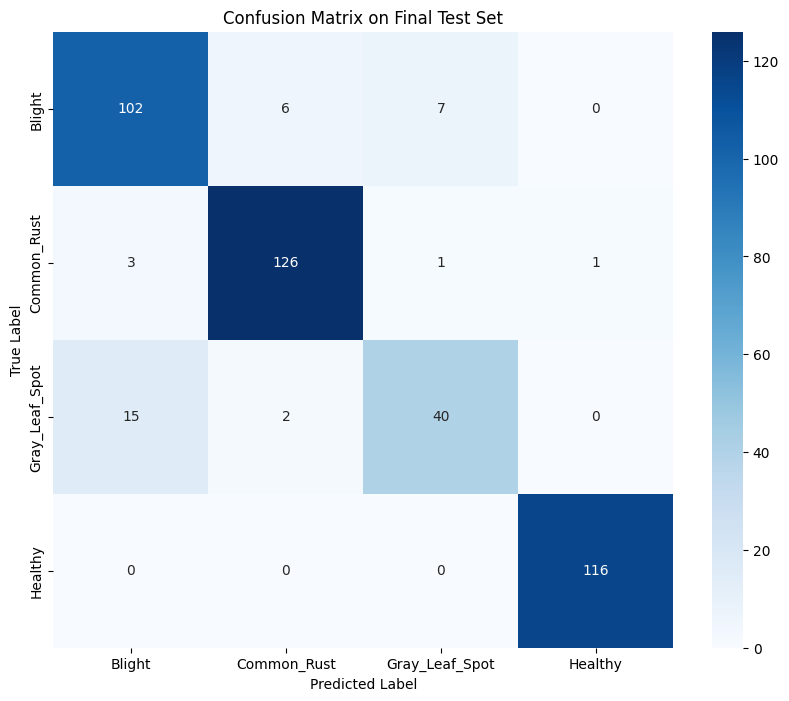

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


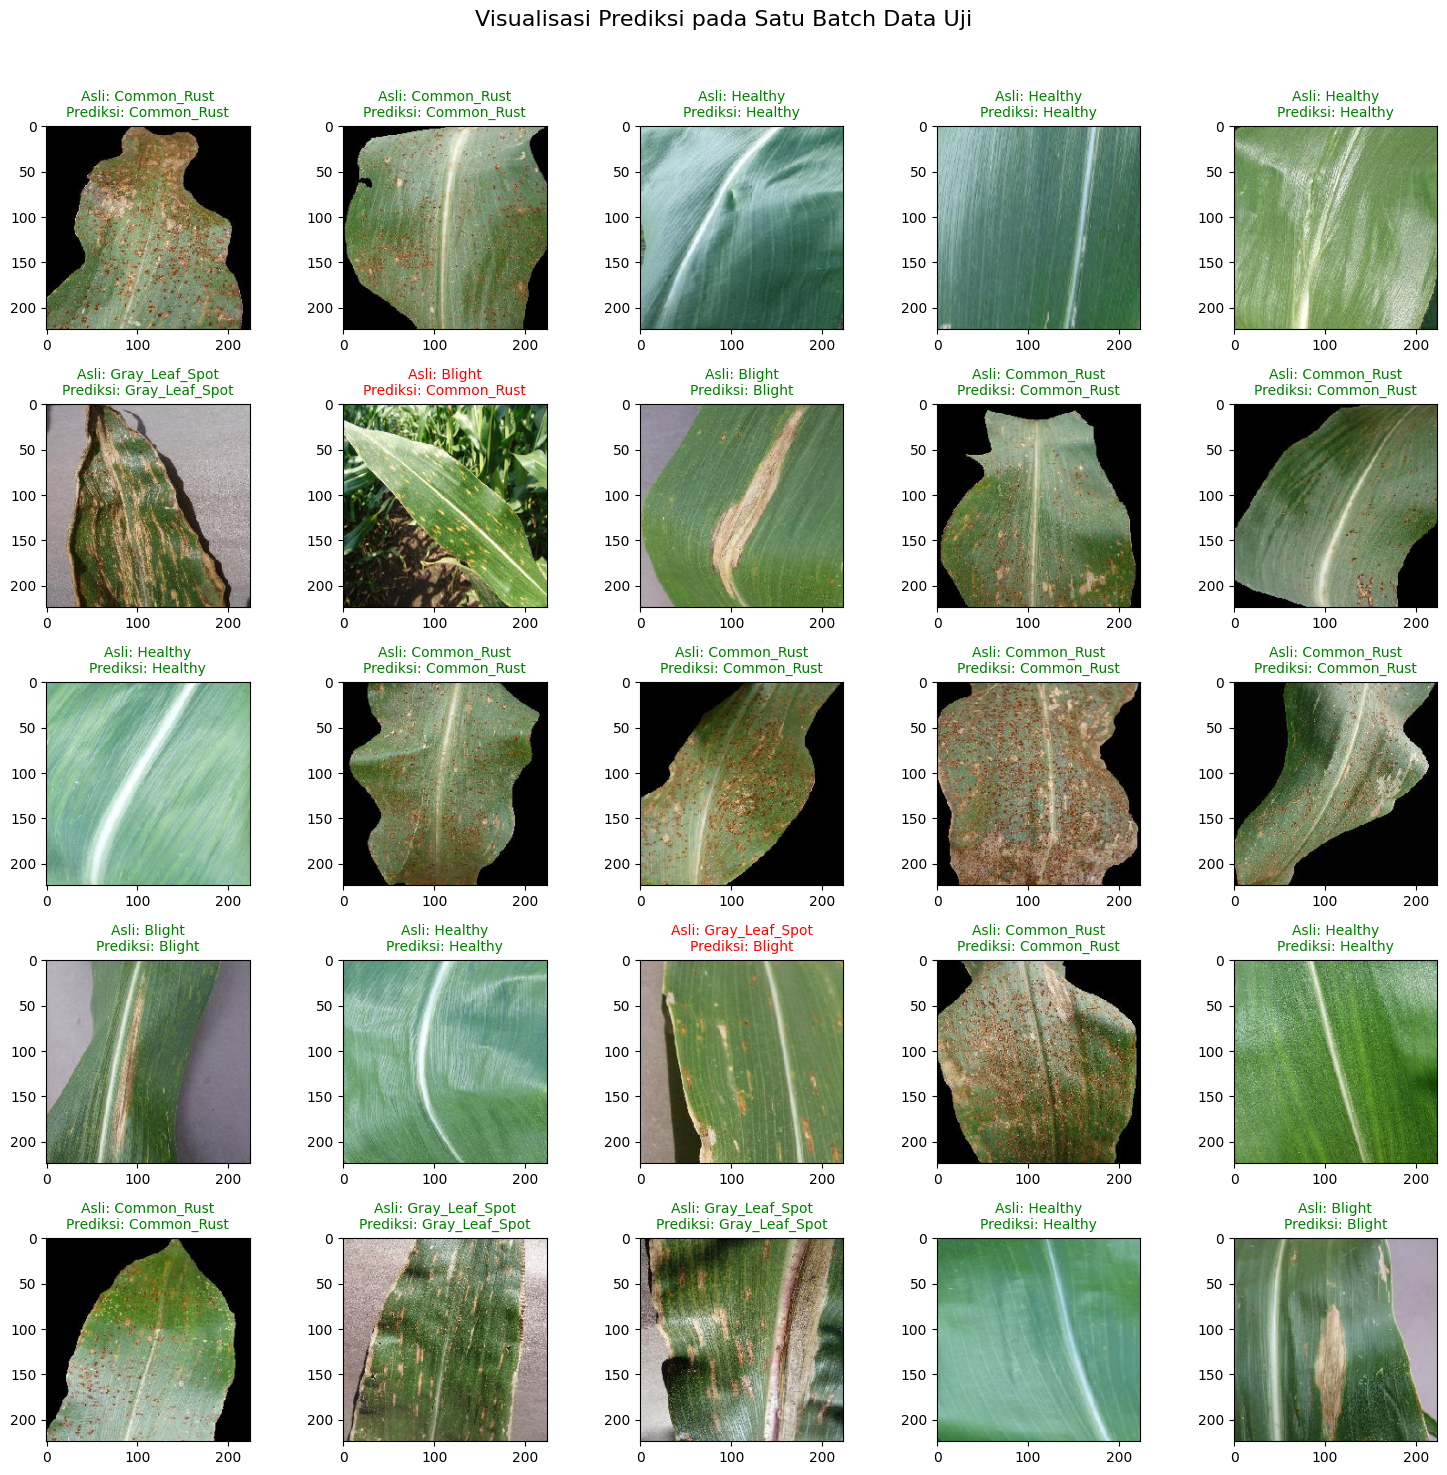

In [8]:
print("\n--- EVALUASI FINAL PADA TEST SET ---")
test_loss, test_accuracy = final_model.evaluate(final_test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

predictions = final_model.predict(final_test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = final_test_generator.classes

print("\n--- LAPORAN KLASIFIKASI ---")
print(classification_report(y_true, y_pred, target_names=classes))

print("\n--- CONFUSION MATRIX ---")
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix on Final Test Set'); plt.show()

def visualize_predictions(model, generator, class_names):
    images, true_labels_one_hot = next(generator)
    predictions_batch = model.predict(images)
    predicted_indices = np.argmax(predictions_batch, axis=1)
    true_indices = np.argmax(true_labels_one_hot, axis=1)
    images_to_show = (images + 1) / 2.0
    plt.figure(figsize=(15, 15))
    plt.suptitle('Visualisasi Prediksi pada Satu Batch Data Uji', fontsize=16)
    num_images = min(len(images), 25)
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images_to_show[i])
        true_label = class_names[true_indices[i]]
        predicted_label = class_names[predicted_indices[i]]
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f"Asli: {true_label}\nPrediksi: {predicted_label}", color=color, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

final_test_generator.reset()
visualize_predictions(final_model, final_test_generator, classes)

Simpan Model Final

In [9]:
model.save("Corn_ResNet50V2_Final.h5")
print("\nModel final berhasil disimpan sebagai 'Corn_ResNet50V2_Final.h5'")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('corn_leaf_disease_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model TFLite berhasil disimpan sebagai 'corn_leaf_disease_model.tflite'")


Model final berhasil disimpan sebagai 'Corn_ResNet50V2_Final.h5'
INFO:tensorflow:Assets written to: C:\Users\R\AppData\Local\Temp\tmpvy35m7xt\assets


INFO:tensorflow:Assets written to: C:\Users\R\AppData\Local\Temp\tmpvy35m7xt\assets


Saved artifact at 'C:\Users\R\AppData\Local\Temp\tmpvy35m7xt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_832')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2884310695184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2884310694032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2884310694800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2884119403920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2884310694224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2884310695376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2884119404880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2884119407568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2884119405264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2884119406800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  28841